# Part 2: Logistic Regression

Logistic regression is a learning algorithm that is used to carry out classification tasks. Here we will see an example of logistic regression on the [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits.

# Setup

First we need to import the relevant modules.

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

# Settings

Here we define some constants that we will be using in this example.

In [3]:
# Settings
NUM_CLASSES = 10
IMG_SIZE = 28

# Hyperparameters
BATCH_SIZE = 4
LEARNING_RATE = 0.001
NUM_EPOCH = 2

# Prepare Data

We can use the ``torchvision.datasets`` module to provide us with the MNIST dataset properly formatted for us to use in PyTorch. Custom datasets can be defined using ``torch.utils.data.Dataset``. After this, we can create a **dataloader** with ``torch.utils.data.DataLoader``. The dataloader combines a dataset and a sampler, and provides an iterable over the given dataset. With this, we can extract samples from the dataset with a loop.

In [4]:
# Create training dataloader
train_set = torchvision.datasets.MNIST(root='./data', 
                                       train=True, 
                                       transform=transforms.ToTensor(), 
                                       download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

# Create testing dataloader
test_set = torchvision.datasets.MNIST(root='./data', 
                                      train=False, 
                                      transform=transforms.ToTensor(), 
                                      download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [5]:
print('Number of training samples:', len(train_set))
print('Number of testing samples:', len(test_set))

Number of training samples: 60000
Number of testing samples: 10000


Shape: torch.Size([1, 28, 28])


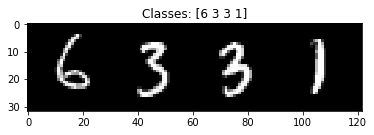

In [6]:
# Load one data batch
inputs, classes = next(iter(train_loader))

# Print image shape
print('Shape:', inputs[0].shape)

# Visualize the data batch
out = torchvision.utils.make_grid(inputs)
plt.imshow(out.permute(1, 2, 0))
plt.title('Classes: ' + str(classes.numpy()))
plt.show()

# Model

Here we use the ``torch.nn`` module to help us define our logistic regression model. The logistic regression model can be seen as a simple single layer neural network.

<img src="images/logistic_regression.png">

In [7]:
# Logistic Regression model
class LogisticRegression(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(BATCH_SIZE, -1) # flatten image into a vector
        x = self.linear(x)
        return x

In [8]:
net = LogisticRegression(IMG_SIZE*IMG_SIZE, NUM_CLASSES)

# Send model to GPU
net = net.cuda()


# Loss Function

We use Cross-Entropy Loss as the cost function to train our model. 

<img src="images/cross_entropy_loss.png">

In [9]:
# Define loss function
criterion = nn.CrossEntropyLoss() # softmax followed by NLL

# Optimization

The ``torch.optim`` module implements optimization algorithms that will help us find the optimal parameters for our model. In our case, we will use Mini-batch Gradient Descent to optimize our model. 

The image below is a 2D representation of optimizating a cost function with gradient descent. The red ball represents our model parameters or weights, _w_, and with each update, we would like to move our ball closer to the global minimum. The "velocity" (direction and magnitude) we move our weights is determined by the gradient of our cost function with respect to the weights. The learning rate, _α_, controls how "far" we would like our weights to move on each update.

<img src="images/optimization_ball_example.png">

In [10]:
# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

# Training the Model

PyTorch has already provided all the necessary tools to allow us to train our model without worrying about lower level implementations. We have already defined everything we need to train our model, all we need to do is call it in the correct sequence. 

Training the model follows a simple pipeline: 

<div align="center">
<b>[sample data] → [forward propagation] → [calculate loss] → [backward propagation] → [update weights]**</b>
</div>

* **Sample data**
    * Get input and corresponding target output from the dataloader
* **Forward propagation**
    * Pass the input through the model and obtain a predicted output
* **Calculate loss**
    * Calculate the discrepancy between the target and prediction using the loss defined earlier
* **Backward propagation**
    * Calculate the loss gradients with respect to the model parameters
* **Update weights**
    * Update the model parameters using the optimizer defined earlier

In [11]:
for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0): # learn from 1 batch
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Send data to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = net(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('Epoch: %d | Batch: %5d | Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Epoch: 1 | Batch:  2000 | Loss: 1.599
Epoch: 1 | Batch:  4000 | Loss: 1.011
Epoch: 1 | Batch:  6000 | Loss: 0.815
Epoch: 1 | Batch:  8000 | Loss: 0.704
Epoch: 1 | Batch: 10000 | Loss: 0.645
Epoch: 1 | Batch: 12000 | Loss: 0.591
Epoch: 1 | Batch: 14000 | Loss: 0.566
Epoch: 2 | Batch:  2000 | Loss: 0.524
Epoch: 2 | Batch:  4000 | Loss: 0.514
Epoch: 2 | Batch:  6000 | Loss: 0.498
Epoch: 2 | Batch:  8000 | Loss: 0.463
Epoch: 2 | Batch: 10000 | Loss: 0.480
Epoch: 2 | Batch: 12000 | Loss: 0.465
Epoch: 2 | Batch: 14000 | Loss: 0.439
Finished Training


# Evaluation

Once we're done training our model, we can **evaluate** it to see how well we have trained it. The **metric** we use in this case is the **accuracy** defined as how many times we correctly predict an input number over the total sum of input data we are using.

In [12]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in test_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 89 %


In [13]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in train_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on train images: 88 %


In [14]:
all_labels = []
all_predictions = []
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            all_labels.append(int(labels[i].to("cpu").numpy()))
            all_predictions.append(int(predicted[i].to("cpu").numpy()))

for i in range(NUM_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 97 %
Accuracy of     1 : 96 %
Accuracy of     2 : 84 %
Accuracy of     3 : 87 %
Accuracy of     4 : 90 %
Accuracy of     5 : 80 %
Accuracy of     6 : 92 %
Accuracy of     7 : 88 %
Accuracy of     8 : 84 %
Accuracy of     9 : 86 %


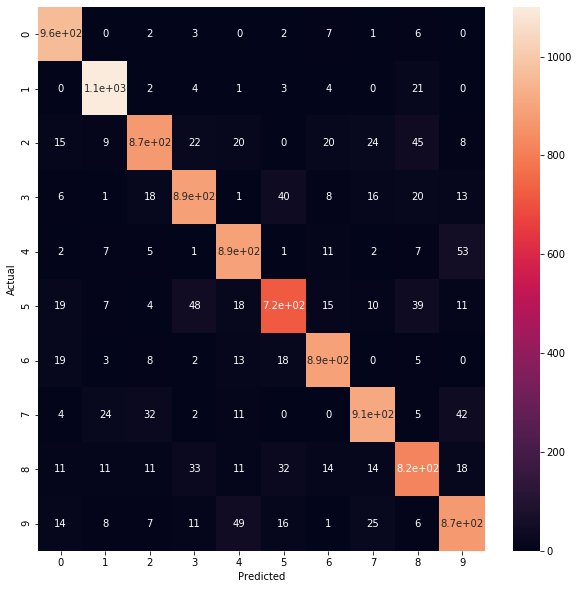

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': all_labels, 'y_Predicted': all_predictions}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

fig, ax = plt.subplots(figsize=(10,10))  
sn.heatmap(confusion_matrix, annot=True, ax=ax)